# Perkenalan

Halo Kak Reviewer! Perkenalkan saya Rafka Imanda Putra dengan username dicoding rafka_imanda.

Dikesempatan kali ini saya akan mengirim submission kedua saya dalam Kelas Belajar Pengembangan Machine Learning.

Adapun dataset yang digunakan bersumber dari https://www.kaggle.com/mnassrib/jena-climate dimana ini adalah dataset yang berisi mengenai 420.551 data cuaca di Jena, Jerman berdasarkan periode dari tahun 2009 - 2016.

Tujuan saya disini adalah membuat model yang mampu memprediksi cuaca dengan Mean Absolute Error dibawah 10% dari skala data 

Mungkin cukup sekian, mari kita mulai pemodelannya!

# Data Understanding

Context --
Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

Content --
Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import io
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

File CSV yang saya gunakan, sudah menghapus beberapa kolom yang tidak digunakan, demi menghemat space saat menguploadnya kesini.

In [4]:
file = files.upload()

Saving jena_climate_2009_2016.csv to jena_climate_2009_2016.csv


In [5]:
df = pd.read_csv(io.BytesIO(file['jena_climate_2009_2016.csv']))

In [6]:
df.head()

,Date Time,T (degC)
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


In [7]:
df.shape

(420551, 2)

In [8]:
df.isnull().sum()

Date Time    0
T (degC)     0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date Time  420551 non-null  object 
 1   T (degC)   420551 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.4+ MB


In [10]:
df.describe()

,T (degC)
count,420551.000000
mean,9.450147
std,8.423365
min,-23.010000
25%,3.360000
50%,9.420000
75%,15.470000
max,37.280000


In [11]:
df.columns = ['date', 'degree']

In [12]:
df['date'] = pd.to_datetime(df['date'])

## Resampling Data

Disini saya ingin mengubah data dari format YY:MM:DD:HH:MM menjadi YY:MM:DD:HH, dan valuenya dirata-ratakan. Selain itu, dengan melakukan resampling ini akan merubah banyaknya jumlah data menjadi sekitar 70.129 data point

In [13]:
df1 = df.set_index('date').resample('H').mean()

In [14]:
df1 = df1.reset_index()
df1.head()

,date,degree
0,2009-01-01 00:00:00,-8.304000
1,2009-01-01 01:00:00,-8.065000
2,2009-01-01 02:00:00,-8.763333
3,2009-01-01 03:00:00,-8.896667
4,2009-01-01 04:00:00,-9.348333


In [15]:
df1.describe()

,degree
count,70041.000000
mean,9.442390
std,8.414647
min,-22.653333
25%,3.358333
50%,9.410000
75%,15.461667
max,37.038333


In [16]:
df1.shape

(70129, 2)

In [17]:
df1.isnull().sum()

date       0
degree    88
dtype: int64

In [18]:
df1['degree'].fillna(df1['degree'].median(), inplace=True)

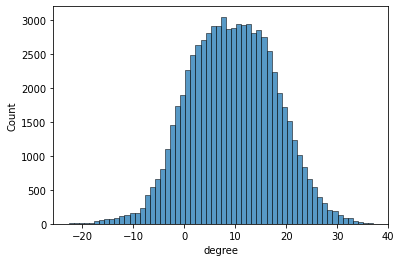

In [19]:
sns.histplot(df1['degree'], bins=60);

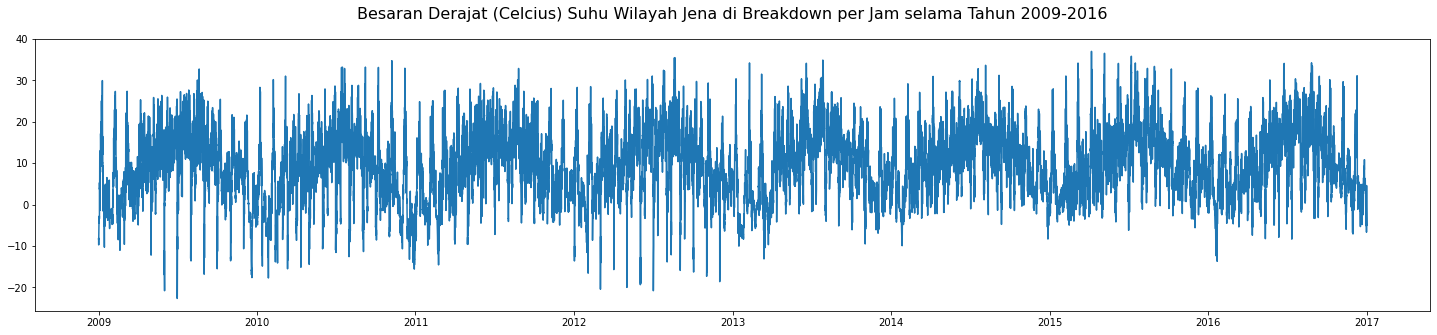

In [20]:
plt.figure(figsize=(25,5))
plt.plot(df1['date'].values, df1['degree'].values)
plt.title('Besaran Derajat (Celcius) Suhu Wilayah Jena di Breakdown per Jam selama Tahun 2009-2016', fontsize=16, pad=20)
plt.show()

# Splitting Validation Data

In [35]:
print(f'Jumlah Data sebanyak {df1.shape[0]}')
print('')
print('Kita ingin membagi dataset menjadi 80% dataset pertama sebagai train_dataset, dan 20% data terakhir sebagai validation_dataset')
print('Maka dengan asumsi itu.....')
print('')
print(f'80% Data Latih, artinya sebanyak {df1.shape[0] * (80 / 100)} Data Terawal')
print('Kita singkat menjadi 56.103 Data Terawal')
print('')
print(f'20% Data Validasi, artinya sebanyak {df1.shape[0] * (20 / 100)} Data Terakhir')
print('Kita singkat menjadi 14.026 Data Terakhir')

Jumlah Data sebanyak 70129

Kita ingin membagi dataset menjadi 80% dataset pertama sebagai train_dataset, dan 20% data terakhir sebagai validation_dataset
Maka dengan asumsi itu.....

80% Data Latih, artinya sebanyak 56103.200000000004 Data Terawal
Kita singkat menjadi 56.103 Data Terawal

20% Data Validasi, artinya sebanyak 14025.800000000001 Data Terakhir
Kita singkat menjadi 14.026 Data Terakhir


In [34]:
jumlah_train = 56103
jumlah_val = 14026 

jumlah_train + jumlah_val == df1.shape[0]

True

In [38]:
df_train = df1.iloc[0:jumlah_train, :].copy()
df_val = df1.iloc[-jumlah_val:, :].copy()

In [39]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x : x.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x : (x[:-1], x[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [41]:
train_set = windowed_dataset(df_train['degree'].values, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(df_val['degree'].values, window_size=60, batch_size=100, shuffle_buffer=1000)

# Modelling

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') < 0.4):
      print('\nYeay, mean absolute error memenuhi target!')
      self.model.stop_training = True

callbacks = myCallback()

In [43]:
model = Sequential([
                    LSTM(60, return_sequences=True),
                    LSTM(60),
                    Dense(30, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(1)
])

In [44]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [45]:
history = model.fit(train_set, epochs=20, validation_data=(validation_set), callbacks=[callbacks])

Epoch 1/20
561/561 [==============================] - 67s 112ms/step - loss: 8.5543 - mae: 9.0409 - val_loss: 5.7752 - val_mae: 6.2539
Epoch 2/20
561/561 [==============================] - 62s 111ms/step - loss: 3.1145 - mae: 3.5773 - val_loss: 2.1758 - val_mae: 2.6208
Epoch 3/20
561/561 [==============================] - 62s 110ms/step - loss: 2.0239 - mae: 2.4668 - val_loss: 1.4971 - val_mae: 1.9230
Epoch 4/20
561/561 [==============================] - 62s 110ms/step - loss: 1.3093 - mae: 1.7133 - val_loss: 0.7731 - val_mae: 1.1413
Epoch 5/20
561/561 [==============================] - 62s 110ms/step - loss: 1.0076 - mae: 1.3807 - val_loss: 0.6276 - val_mae: 0.9774
Epoch 6/20
561/561 [==============================] - 62s 110ms/step - loss: 0.9071 - mae: 1.2666 - val_loss: 0.5549 - val_mae: 0.8889
Epoch 7/20
561/561 [==============================] - 62s 110ms/step - loss: 0.8333 - mae: 1.1812 - val_loss: 0.5080 - val_mae: 0.8333
Epoch 8/20
561/561 [==============================] - 6

# Plot Loss dan Metrik MAE

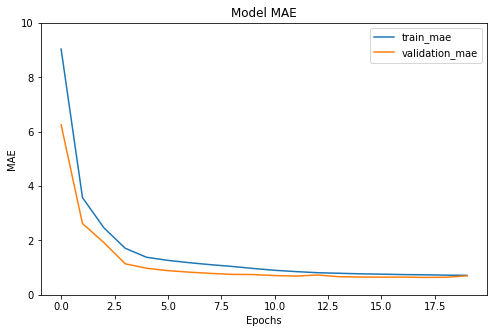

In [46]:
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='validation_mae')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.ylim(ymin=0, ymax=10)
plt.show()

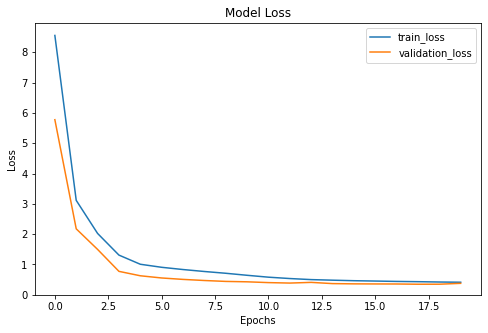

In [47]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(ymin=0)
plt.show()

In [66]:
print(df1['degree'].min(), df1['degree'].max())
print('Range Data = {}'.format(np.abs(df1['degree'].min()) + df1['degree'].max()))

-22.653333333333336 37.038333333333334
Range Data = 59.69166666666667


In [60]:
# Mencari Skala Data

from sklearn.preprocessing import MinMaxScaler

data = np.array([df1['degree'].min(), df1['degree'].max(), df['degree'].min() + 0.6959]).reshape(-1,1)   # 0,6959 adalah hasil MAE data validasi
scaler = MinMaxScaler()

scaler.fit_transform(data)

array([[0.        ],
       [1.        ],
       [0.00568309]])

Berdasarkan hasil normalisasi hasil MAE dari data validasi, model ini memiliki MAE < 10% skala data.

# Conclusion

Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel. -- DONE

Harus menggunakan LSTM dalam arsitektur model. -- DONE

Validation set sebesar 20% dari total dataset. -- DONE

Model harus menggunakan model sequential. -- DONE

Harus menggunakan Learning Rate pada Optimizer. -- DONE

Dataset yang digunakan memiliki banyak sampel data. -- DONE

Mengimplementasikan Callback. -- DONE

Membuat plot loss dan akurasi pada saat training dan validation. -- DONE

dataset memiliki minimal 10000 sampel data. -- DONE

MAE dari model < 10% skala data. -- DONE